# Poisson Regression on Video Game Sales Data

In [91]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from dateutil import parser as ps
import datetime as dt
from workalendar.usa import UnitedStates
from workalendar.asia import SouthKorea, China, Japan
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.discrete.discrete_model as smd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import scipy.stats as stats

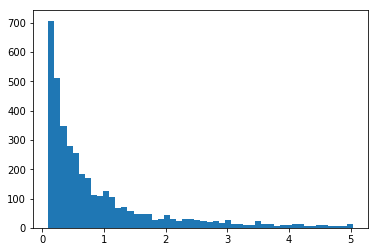

In [92]:
df=pd.read_pickle('./df_with_features.zip',compression = 'zip')
df_features = df.drop(columns = ['release_date','release_year','game','console','publisher'])

# Selects first column on left as the targeted and all columns on right as features
def patsy_string_from_df(df_features):
    patsy_string = df_features.columns[0] + " ~ "
    print('Predicted variable: ' + df_features.columns[0])
    for title in df_features.columns[1:]:
        patsy_string += title + " + "
    #remove last plus and spaces from string
    patsy_string=patsy_string[:-3]
    print(patsy_string)
    return patsy_string

#Uses above patsy string to make OLS model
def sm_OLS_model(df_features):
    y, X = patsy.dmatrices(patsy_string_from_df(df_features), data=df_features, return_type="dataframe")
    model = sm.OLS(y, X)
    # Fit your model to your training set
    fit = model.fit()

    # Print summary statistics of the model's performance
    return fit
# Drop outliers above 95%
outlier_cutoff = np.percentile(df_features['total_shipped_in_mil'].values,95)
df_features =\
df_features.loc[df_features['total_shipped_in_mil'] < outlier_cutoff]


# It looks like release date proximity to holidays doesn't really have an impact on total sales. Let's drop those
df_features.drop(columns = ['near_sk_holiday','near_jp_holiday','near_cn_holiday'],inplace = True)
plt.hist(df_features['total_shipped_in_mil'],bins = 50);

In [93]:
df_features.head()

,total_shipped_in_mil,average_rating,near_us_holiday,years_since_release,top_10_publisher
12973,0.1,8.0,False,8.978082,False
13019,0.1,5.7,False,8.920548,False
13103,0.1,3.5,False,8.882192,False
13123,0.1,6.8,False,8.863014,False
9572,0.1,8.2,False,10.854795,False


In [95]:
#Not log'd


y = df_features['total_shipped_in_mil'].values
# Can't use log'd data because poisson requires integer predictions?
#y = df_features.iloc[:,-1].values
X = df_features.iloc[:,1:]
y

# Cast variables to correct datatypes
y = y.astype(float)
X = X.astype(float)

X_train, X_val, y_train, y_val = \
    train_test_split(X, y, test_size=0.2, random_state=42)



In [96]:
# Fit GLM in statsmodels using Poisson link function
poisson_model = sm.GLM(y_train, X_train, family = sm.families.Poisson())
#poisson_model = sm.GLM(y, X, family = sm.families.NegativeBinomial())

poisson_result = poisson_model.fit()
poisson_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 3039
Model:                            GLM   Df Residuals:                     3035
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3700.9
Date:                Thu, 18 Apr 2019   Deviance:                       2507.6
Time:                        10:27:41   Pearson chi2:                 3.09e+03
No. Iterations:                     5   Covariance Type:             nonrobust
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
average_rating          0.0125      0.006      2.058      0.040       0.001       0.024
near_us_holiday         0.0304      0.071      0.427      0.669      -0.109       0.170
years_since_release    -0.0239      0.004     -6.671      0.000      -0.031      -0.017
top_10_publisher        0.2767      0.037      7.445      0.000       0.204       0.350
=======================================================================================
"""

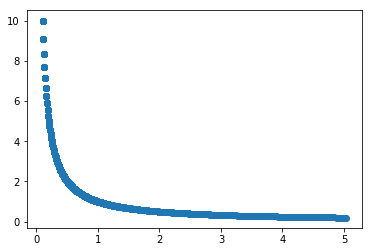

In [99]:
plt.scatter(yval,1/yval)

RMSE / max_val:  0.1958
MAE / max_val:  0.1451
RMSE:  0.984901376794213
MAE:  0.7299443504211536


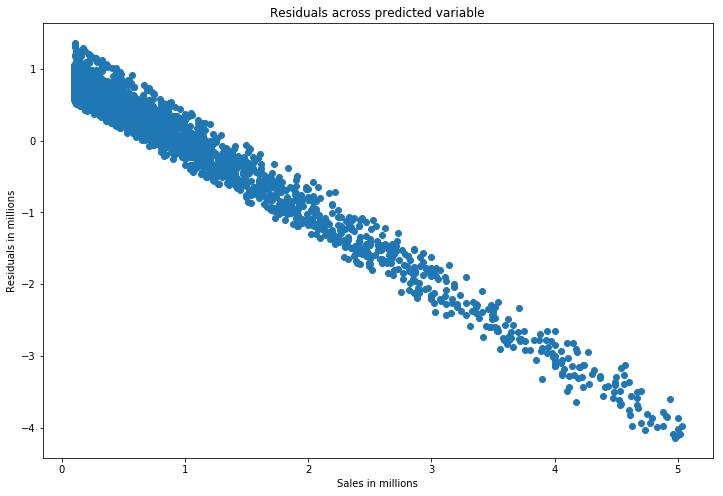

In [97]:
# Calculate root mean squared error
ypred = poisson_result.predict(X_train)
yval = y_train
residuals_squared = list()
residuals_abs = list()
residuals = list()
for i in range(0,len(yval)):
    residuals.append(ypred.values[i]-yval[i])
    residuals_squared.append((ypred.values[i]-yval[i])**2)
    residuals_abs.append(abs(ypred.values[i] - yval [i]))

rmse = np.sqrt(sum(residuals_squared)/len(yval))
mae = sum(residuals_abs)/len(yval)
max_val = df_features['total_shipped_in_mil'].max()
print("RMSE / max_val: " ,(rmse/max_val).round(4))
print("MAE / max_val: ",(mae/max_val).round(4))
print("RMSE: ",rmse)
print("MAE: ", mae)
plt.figure(figsize=(12,8))
plt.scatter(yval,residuals)
plt.xlabel("Sales in millions")
plt.ylabel("Residuals in millions")
plt.title('Residuals across predicted variable');